# Drzewa decyzyjne
Drzewa decyzyjne to metoda uczenia nadzorowanego stosowana do klasyfikacji i regresji. Jej celem jest stworzenie modelu, który przewiduje wartość zmiennej docelowej poprzez naukę prostych reguł decyzyjnych wywnioskowanych z cech danych.

Drzewo jest strukturą danych zbudowaną z elementów, które nazywamy **węzłami (nodes)**. Pierwszy węzeł drzewa nazywa się **korzeniem (root node)**. Od niego "wyrastają" pozostałe węzły, które będziemy nazywać **dziećmi (child nodes)**. Węzeł nadrzędny w stosunku do danego węzła potomnego nazywamy **rodzicem (parent node)**. Jeśli węzeł nie posiada dzieci, to nazywa się **liściem (leaf node)**.




## Import bibliotek i wczytanie danych

Wykorzystany zostanie zbiór danych: [loan_data.xlsx](data/loan_data.xlsx) zawierający dane o kredytobiorcach i decyzji o przyznaniu kredytu.

In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

df = pd.read_excel("data/loan_data.xlsx")
df.head()


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360,1,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360,1,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360,1,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360,1,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360,1,Urban,Y


## Przygotowanie danych

Wykorzystywana klasa DecisionTreeClassifier wymaga aby dane:
* nie zawierały brakujących wartości
* wykorzystywały tzw. **zmienne fikcyjne (dummy variables)**
* były typu **numerical**


In [109]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Dane nie zawierają pustych kolumn. Możemy przejść do kolejnego kroku. Dokonamy teraz zamiany typu kolumn z object na int64.

In [110]:
df.dtypes

Gender                object
Married               object
Dependents             int64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term       int64
Credit_History         int64
Property_Area         object
Loan_Status           object
dtype: object

In [111]:
df.select_dtypes(include=['object']).nunique()

Gender           2
Married          2
Education        2
Self_Employed    2
Property_Area    3
Loan_Status      2
dtype: int64

W przypadku kolumn z 2 różnymi wartościami wystarczy dokonać prostego mapowania na wartości 0 i 1.

In [112]:
df["Gender"] = df["Gender"].map(lambda x: 1 if x == "Male" else 0)
df["Married"] = df["Married"].map(lambda x: 1 if x == "Yes" else 0)
df["Education"] = df["Education"].map(lambda x: 1 if x == "Graduate" else 0)
df["Self_Employed"] = df["Self_Employed"].map(lambda x: 1 if x == "Yes" else 0)
df["Loan_Status"] = df["Loan_Status"].map(lambda x: 1 if x == "Y" else 0)

W przypadku kolumny *Property_Area* musimy zastosować metodę **get_dummies()** aby zakodować ją w formacie **One Hot**.

In [113]:
df = pd.get_dummies(df, columns=["Property_Area"])

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,0,1,0,5849,0.0,146.412162,360,1,1,False,False,True
1,1,1,1,1,0,4583,1508.0,128.000000,360,1,0,True,False,False
2,1,1,0,1,1,3000,0.0,66.000000,360,1,1,False,False,True
3,1,1,0,0,0,2583,2358.0,120.000000,360,1,1,False,False,True
4,1,0,0,1,0,6000,0.0,141.000000,360,1,1,False,False,True


Teraz nasze dane są gotowe do uczenia. Ostatnim etapem jest podzielenie danych na **zbiór cech niezależnych** i **zbiór cech zależnych**, a następnie przekonwertujemy dane na typ **float**.

In [114]:
x = df.drop(columns=["Loan_Status"]).astype(np.float64)
y = df["Loan_Status"].astype(np.float64)

## Uczenie modelu

Wykorzystamy do tego klasę **DecisionTreeClassifier**. Następnie możemy narysować drzewo za pomocą **plot_tree**.
Dla drzewa ustawiamy maksymalną głębokość na 3, aby zwiększyć jego czytelność.

W **plot_tree** ustawiamy **feature_names** nazwy cech (kolumny ze zbioru cech niezależnych) na, a w **class_names** etykiety sklasyfikowanych danych.

Ustawienie **random_state** w funkcji **train_test_split** spowoduje zawsze taki sam podział na dane treningowe i testowe.

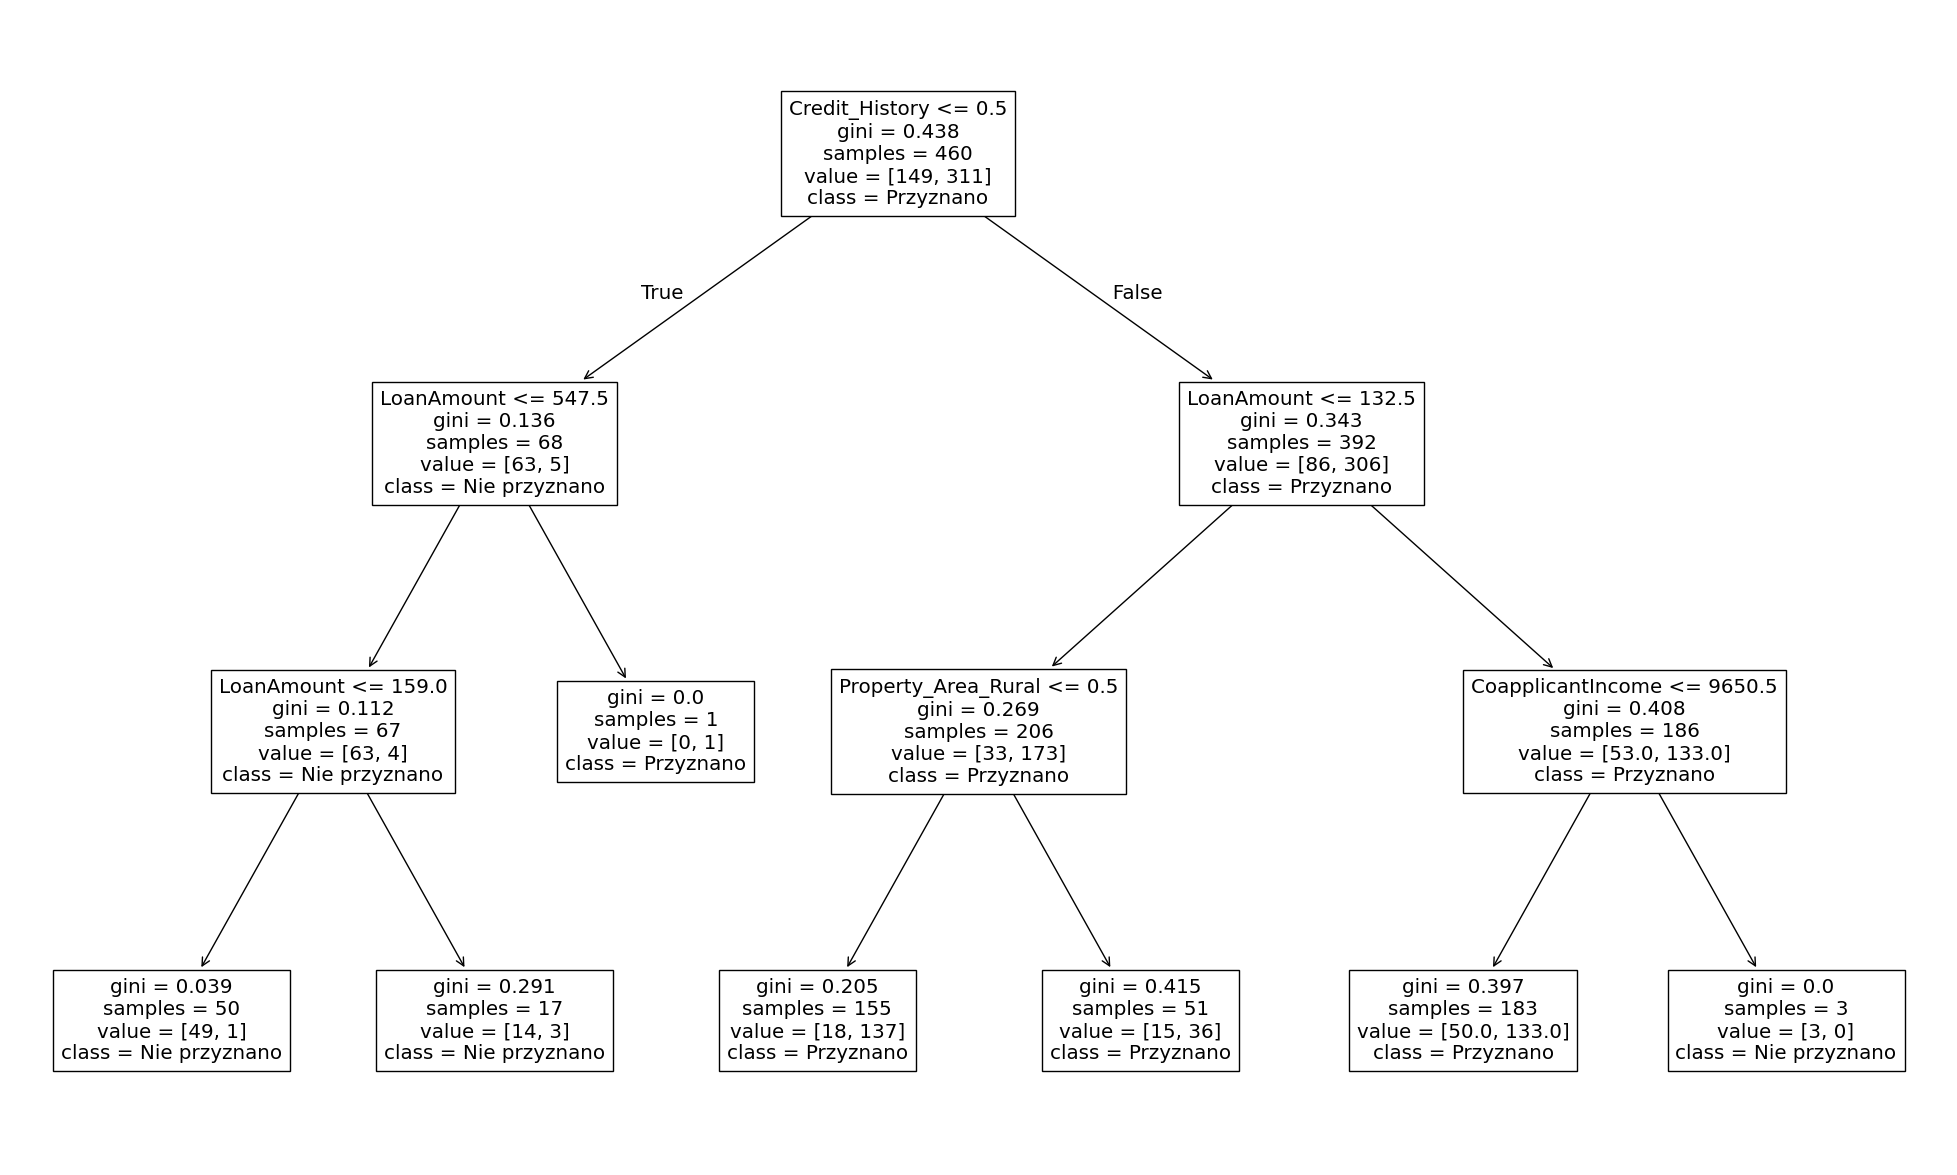

In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
model = DecisionTreeClassifier(max_depth=3).fit(x_train, y_train)

plt.figure(figsize=(25, 15))
plot_tree(model, feature_names=x.columns, class_names=['Nie przyznano', 'Przyznano'])
plt.show()


Na początku każdego węzła znajduje się warunek, przyporządkujący próbkę do niższego węzła/liścia.

Indeks **gini** określa zróżnicowanie próbek. Jeśli liczba próbek spełniających warunek jest taka sama jak liczba niespełniająca, wynosi on 1. Gdyby np. wszystkie próbki spełniały warunek, **gini** równy byłby 0.
$$ Gini = 1 - \sum_{i=1}^{k} p_i^2 $$

**Samples** jest równy liczbie próbek, a **values** ich przydziałowi do klas.

**Class** określa dominującą klasę w węźle/liściu.

## Mierzenie skuteczności modelu

Graficznym sposobem przedstawienia poprawności klasyfikacji jest wygenerowanie **macierzy pomyłek (confusion matrix)**.

Sprawdza przewidywania modelu z rzeczywistymi etykietami, przedstawiając liczbę prawidłowych i błędnych klasyfikacji.

Nasza macierz składa się z 4 pól:

**True Positives (TP)**: liczba poprawnie sklasyfikowanych pozytywnych przypadków.

**True Negatives (TN)**: liczba poprawnie sklasyfikowanych negatywnych przypadków.

**False Positives (FP)**: liczba przypadków, które zostały błędnie sklasyfikowane jako pozytywne.

**False Negatives (FN)**: liczba przypadków, które zostały błędnie sklasyfikowane jako negatywne.

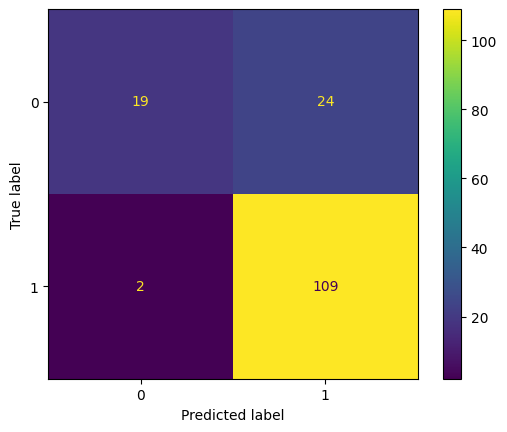

In [24]:
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()

Dodatkowymi metrykami wykorzystywanymi do analizy modelu są:

**Precyzja (precision)**: odsetek poprawnych przewidywań pozytywnej klasy spośród wszystkich przypadków oznaczonych przez model jako pozytywne.

$$ Precyzja = \frac{TP}{TP + FP} $$

**Czułość (recall)**: odsetek rzeczywistych przypadków pozytywnych, które model poprawnie wykrył spośród wszystkich rzeczywistych pozytywów.

$$ Czulosc = \frac{TP}{TP + FN} $$

**Wskaźnik F1**: średnia harmoniczna precyzji i czułości, łącząca obie miary w jedną wartość.
$$ F1 = \frac{2*Precyzja*Czulosc}{Precyzja + Czulosc} $$

**Dokładność (accuracy)**: odsetek poprawnie sklasyfikowanych próbek (zarówno pozytywnych, jak i negatywnych) spośród wszystkich próbek.
$$ Dokladnosc = \frac{TP + TN}{Wszystkie} $$

**Support**: zlicza ile przypadków wystąpiło w zbiorze.

**Macro avg** – średnia arytmetyczna metryk dla każdej klasy, traktując je równoważnie.

**Weighted avg** – średnia ważona według liczby próbek (supportu) w każdej klasie.


In [117]:
print(classification_report(y_test, y_pred, target_names=["Nie przyznano", "Przyznano"]))

               precision    recall  f1-score   support

Nie przyznano       0.90      0.44      0.59        43
    Przyznano       0.82      0.98      0.89       111

     accuracy                           0.83       154
    macro avg       0.86      0.71      0.74       154
 weighted avg       0.84      0.83      0.81       154

